In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time_series.time_series_models import KernelRidgeRegression
from time_series.kernels import GaussianKernel

2025-11-19 12:27:45.611 | INFO     | time_series.config:<module>:13 - PROJ_ROOT path is: /home/james/Repo/PhD Repo/time_series_clustering


In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score

In [3]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

In [4]:
import itertools
import tqdm

In [5]:
class DataHolder:
    def __init__(self, **kwargs):
        self.update(**kwargs)
    
    def update(self, **kwargs):
        self.__dict__.update(kwargs)

In [6]:
class GridSearch:
    def __init__(self, estimator, param_grid, scoring=None, nfolds=5):
        self.estimator = estimator
        self.param_grid = param_grid
        self.scoring = scoring if scoring else mean_squared_error
        self.nfolds = nfolds
    
    def fit(self, X, y=None):
        param_names = list(self.param_grid.keys())
        param_values = list(itertools.product(*self.param_grid.values()))

        result = []

        best_score = np.inf
        best_params = []
        
        for p in param_values:
            mapping = {param_names[i]:p[i] for i in range(len(param_names))}
            model = self.estimator(**mapping)

            kf = KFold(n_splits=self.nfolds, random_state=None, shuffle=False)
            scores = []
            
            for i, (train_index, test_index) in enumerate(kf.split(X)):
                X_train = X[train_index]
                X_test = X[test_index]

                y_train = y[train_index]
                y_test = y[test_index] 

                model.fit(X_train, y_train)

                y_pred = model.predict(X_test)

                score = self.scoring(y_test, y_pred)
                scores.append(score)
            
            cv_score = np.mean(scores)
            result.append(
                (mapping, cv_score)
            )

            if cv_score < best_score:
                best_score = cv_score
                best_params = p
        
        self.best_score = best_score
        self.best_params = best_params

        self.cv_results = result


In [7]:
class KRRWrapper(BaseEstimator):
    def __init__(self, bandwidth, reg):
        self.model = KernelRidgeRegression(
            kernels=[GaussianKernel(bandwidth=bandwidth)],
            reg = reg
        )

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

In [8]:
def generate_time_series(x0, f, N=200):
    x = np.zeros(shape=(N))
    x[0] = x0
    for i in range(1, N):
        x[i] = f(x[i-1])
    return x

In [9]:
epsilon = 0

f1 = lambda x: np.sin(x) + epsilon*np.random.normal(0, 1)
f2 = lambda x: np.sin(2*x) + epsilon*np.random.normal(0, 1)

x = np.linspace(0, 6, 50)

y1 = f1(x)
y2 = f2(x)

dataset_1 = DataHolder(
    x=x,
    y=y1,
    f=f1
)

dataset_21 = DataHolder(
    x=x,
    y=y2,
    f=f2
)

dataset_22 = DataHolder(
    x=x,
    y=y2,
    f=f2
)

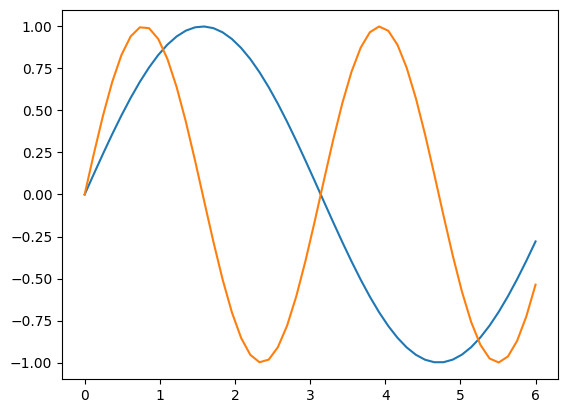

In [10]:
plt.plot(x, y1)
plt.plot(x, y2)

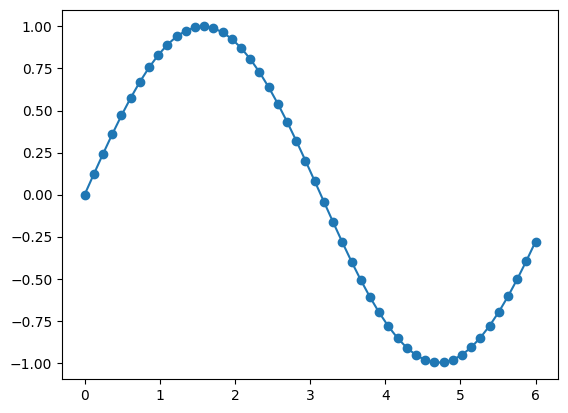

In [11]:
# Fit curve 1
model = KernelRidgeRegression(
        kernels=[GaussianKernel(bandwidth=1)],
        reg = 1e-9
    )

model.fit(x, y1)

y_pred = model.predict(x)

plt.scatter(x, y1)
plt.plot(x, y_pred)

dataset_1.update(
    alpha = model.alpha,
    bandwidth = 1,
    model=model
)

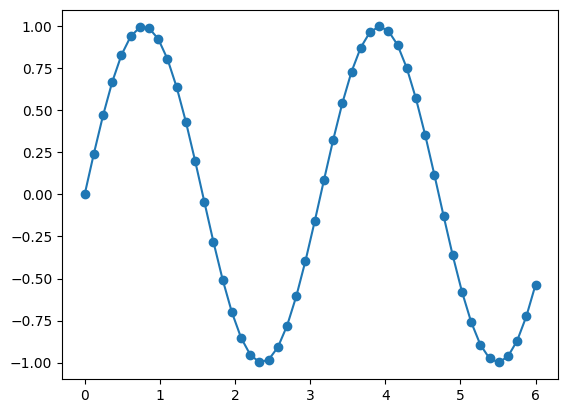

In [12]:
# Fit curve 2
model2 = KernelRidgeRegression(
        kernels=[GaussianKernel(bandwidth=1)],
        reg = 1e-7
    )

model2.fit(x, y2)

y_pred = model2.predict(x)

plt.scatter(x, y2)
plt.plot(x, y_pred)

dataset_21.update(
    alpha = model2.alpha,
    bandwidth = 1,
    model = model2
)

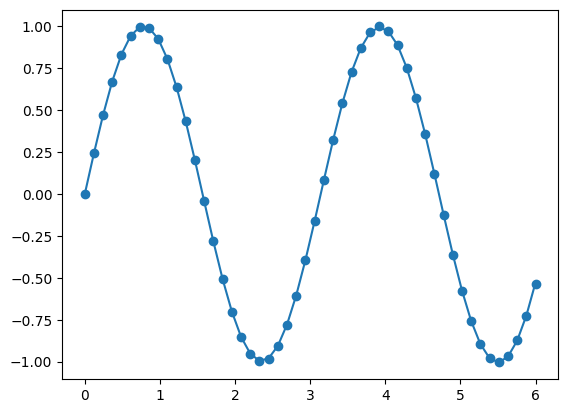

In [13]:
# Fit curve 2
model2 = KernelRidgeRegression(
        kernels=[GaussianKernel(bandwidth=2)],
        reg = 1e-7
    )

model2.fit(x, y2)

y_pred = model2.predict(x)

plt.scatter(x, y2)
plt.plot(x, y_pred)

dataset_22.update(
    alpha = model2.alpha,
    bandwidth = 2,
    model=model2
)

In [14]:
def distance(ds1, ds2):
    # k1 = GaussianKernel(bandwidth=ds1.bandwidth)
    # k2 = GaussianKernel(bandwidth=ds2.bandwidth)
    kc = GaussianKernel(bandwidth=1)

    d11 = ds1.alpha.T@kc(ds1.x/ds1.bandwidth, ds1.x/ds1.bandwidth)@ds1.alpha
    d22 = ds2.alpha.T@kc(ds2.x/ds2.bandwidth, ds2.x/ds2.bandwidth)@ds2.alpha
    d12 = ds1.alpha.T@kc(ds1.x/ds1.bandwidth, ds2.x/ds2.bandwidth)@ds2.alpha

    return (d11 + d22 - 2*d12)[0][0], d11, d22, d12

In [15]:
distance(dataset_1, dataset_21)

(np.float64(13.169117772698097),
 array([[3.40516534]]),
 array([[13.36680787]]),
 array([[1.80142772]]))

In [16]:
distance(dataset_1, dataset_22)

(np.float64(2689.1995752519165),
 array([[3.40516534]]),
 array([[2681.32359923]]),
 array([[-2.23540534]]))

In [17]:
mean_squared_error(
    dataset_21.model.predict(dataset_21.x),
    dataset_21.y
)

3.850373011645263e-09

In [18]:
dataset_1.alpha.T@GaussianKernel(1)(dataset_1.x, dataset_21.x)@dataset_21.alpha

array([[1.80142772]])

In [19]:
mean_squared_error(
    dataset_22.model.predict(dataset_22.x),
    dataset_22.y
)

9.610781733224053e-06

In [20]:
dataset_22.alpha.T@GaussianKernel(2)(dataset_22.x, dataset_22.x)@dataset_22.alpha

array([[2681.32359923]])

In [21]:
alpha_t = np.linalg.inv(GaussianKernel(1)(dataset_22.x/2, dataset_22.x/2) + 1e-9*np.eye(len(dataset_22.x)))@GaussianKernel(2)(dataset_22.x, dataset_22.x)@dataset_22.alpha

In [22]:
mean_squared_error(
    GaussianKernel(1)(dataset_22.x/2, dataset_22.x/2)@alpha_t,
    dataset_22.y
)

6.764142269976383e-05

In [23]:
xt = np.arange(5)
k1 = GaussianKernel(1)
k2 = GaussianKernel(2)

np.linalg.inv(k1(xt/2, xt/2))@k2(xt, xt)

array([[ 1.00000000e+00,  1.27529858e-13,  1.41525611e-13,
         1.43532032e-13,  1.10134124e-13],
       [-1.71145571e-13,  1.00000000e+00, -2.68646272e-13,
        -2.67660707e-13, -2.13162821e-13],
       [ 1.07898091e-13,  1.45196566e-13,  1.00000000e+00,
         1.70294514e-13,  1.42108547e-13],
       [-2.91132600e-14, -2.79686061e-14,  2.95273061e-15,
         1.00000000e+00, -2.84217094e-14],
       [-1.25071574e-15, -1.11963464e-14, -1.47097192e-14,
        -3.89008106e-15,  1.00000000e+00]])